In [1]:
import pandas as pd
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-notebook')

In [113]:
demographics = pd.read_excel('oasis_cross-sectional.xls', sheetname=3) # load data
df = demographics.dropna(how='any') # remove NaN values
df_columns = list(demographics.columns)
X_columns = np.delete(df_columns, [6,7], None) # X matrix won't have MMSE or CDR scores
Xdf = df.reindex(columns=X_columns)
X = Xdf.values # creating X
HealthyExampleIndex = 27
SickExampleIndex = 145
print(X_columns)
print(X[27])
print(X[145])

['ID' 'M/F' 'Hand' 'Age' 'Educ' 'SES' 'eTIV' 'nWBV' 'ASF']
['OAS1_0058_MR1' 'F' 'R' 46 5.0 1.0 1584.7 0.817 1.10747]
['OAS1_0308_MR1' 'F' 'R' 78 3.0 3.0 1401.13 0.703 1.25256]


C:\Users\Shak3\Anaconda3\lib\site-packages\pandas\util\_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [3]:
# Define function to get list of pngs based on slice number
pngs_path='OASIS_MR1_pngs'
def getcoronalPNG(path):
    l = []
    coronalslice90_files = []
    coronalslice91_files = []
    coronalslice92_files = []
    coronalslice93_files = []
    coronalslice94_files = []
    coronalslice95_files = []
    coronalslice96_files = []
    coronalslice97_files = []
    coronalslice98_files = []
    coronalslice99_files = []
    
    for root, directories, filenames in os.walk(path):
        
        for filename in filenames:
            if ".90." in filename: 
                coronalslice90_files.append(os.path.join(root, filename))
            if ".91." in filename: 
                coronalslice91_files.append(os.path.join(root, filename))
            if ".92." in filename: 
                coronalslice92_files.append(os.path.join(root, filename))
            if ".93." in filename: 
                coronalslice93_files.append(os.path.join(root, filename))
            if ".94." in filename: 
                coronalslice94_files.append(os.path.join(root, filename))
            if ".95." in filename: 
                coronalslice95_files.append(os.path.join(root, filename))
            if ".96." in filename: 
                coronalslice96_files.append(os.path.join(root, filename))
            if ".97." in filename: 
                coronalslice97_files.append(os.path.join(root, filename))
            if ".98." in filename: 
                coronalslice98_files.append(os.path.join(root, filename))
            if ".99." in filename: 
                coronalslice99_files.append(os.path.join(root, filename))

    l = list(zip(coronalslice90_files, coronalslice91_files, coronalslice92_files, coronalslice93_files, coronalslice94_files, coronalslice95_files, coronalslice96_files, coronalslice97_files, coronalslice98_files, coronalslice99_files))

    return ((np.asarray(l)))

coronal_files0 = getcoronalPNG(pngs_path)
coronal_X_files = np.take(coronal_files0, indices=df.index.values, axis=0) # keeps the images with the same index as X matrix
coronal90loc, coronal91loc, coronal92loc, coronal93loc, coronal94loc, coronal95loc, coronal96loc, coronal97loc, coronal98loc, coronal99loc = zip(*coronal_X_files)

In [4]:
X_id, X_sex, X_handedness, X_age, X_education, X_SES, X_eTIV, X_nWBV, X_ASF = zip(*X) # unzips big X matrix

def sex_translator(X_sex):
    X_sex_binary = []
    X_sex_encoded = []
    for x in X_sex:
        if x == 'M':
            X_sex_binary.append(1)
            X_sex_encoded.append([0,1])
        else:
            X_sex_binary.append(-1)
            X_sex_encoded.append([1,0])
    
    return(zip(X_sex_binary, X_sex_encoded)) # gives us binary and one-hot encoded for sex
           
def hand_translator(X_handedness):
    X_hand_binary = []
    X_hand_encoded = []
    for x in X_handedness:
        if x == 'R':
            X_hand_binary.append(1)
            X_hand_encoded.append([0,1])
        else:
            X_hand_binary.append(-1)
            X_hand_encoded.append([1,0])
    
    return(zip(X_hand_binary, X_hand_encoded)) # same as above but for handedness

# turns out all the patients are right-handed
# maybe we should all just be left-handed so we don't suffer from Alzheimer's
# /frequentist sarcasm

X_sex_binary, X_sex_encoded = zip(*sex_translator(X_sex)) # unzipping to get our function outputs
X_hand_binary, X_hand_encoded = zip(*hand_translator(X_handedness))

In [5]:
def prepPNGimgs(array_of_image_paths):
    l = []
    for img_file in array_of_image_paths: # for each file in the list of images...
        img = cv2.imread("{}".format(img_file)) # read the image...
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_scaled = (np.divide(gray, np.amax(gray)))
        l.append(gray_scaled)
    
    return(np.asarray(l))

In [6]:
Y_CDR_columns = [column_name for column_name in df_columns if column_name == 'CDR']
Y_CDR_df = df.reindex(columns=Y_CDR_columns)
Y_CDR = Y_CDR_df.values

Y_MMSE_columns = [column_name for column_name in df_columns if column_name == 'MMSE']
Y_MMSE_df = df.reindex(columns=Y_MMSE_columns)
Y_MMSE = Y_MMSE_df.values

CDR_threshold_0 = 0 # threshold values by CDR scale
CDR_threshold_0point5 = 0.5
CDR_threshold_1 = 1

MMSE_threshold_24 = 24 # threshold values by MMSE scale
MMSE_threshold_18 = 18

def CDR_probable_AD_thresholder(Y_CDR, threshold_value):
    Y_CDR_binary = []
    Y_CDR_encoded = []
    for y in Y_CDR:
        if y > threshold_value:
            Y_CDR_binary.append(1)
            Y_CDR_encoded.append([0,1])
        else:
            Y_CDR_binary.append(-1)
            Y_CDR_encoded.append([1,0])

    return((zip(Y_CDR_binary, Y_CDR_encoded)))

def MMSE_probable_Dementia_thresholder(Y_MMSE, threshold_value):
    Y_MMSE_binary = []
    Y_MMSE_encoded = []
    for y in Y_MMSE:
        if y < threshold_value:
            Y_MMSE_binary.append(1)
            Y_MMSE_encoded.append([0,1])
        else:
            Y_MMSE_binary.append(-1)
            Y_MMSE_encoded.append([1,0])
        
    return(zip(Y_MMSE_binary, Y_MMSE_encoded))

Y_CDR_binary, Y_CDR_encoded = zip(*CDR_probable_AD_thresholder(Y_CDR, CDR_threshold_0))
Y_MMSE_binary, Y_MMSE_encoded = zip(*MMSE_probable_Dementia_thresholder(Y_MMSE, MMSE_threshold_24))

In [7]:
# turning everything into numpy arrays because why not

df_index = np.asarray(df.index.values)
X_id = np.asarray(X_id)
X_sex = np.asarray(X_sex)
X_sex_binary = np.asarray(X_sex_binary)
X_sex_encoded = np.asarray(X_sex_encoded)
X_handedness = np.asarray(X_handedness)
X_hand_binary = np.asarray(X_hand_binary)
X_hand_encoded = np.asarray(X_hand_encoded)
X_age = np.asarray(X_age) 
X_education = np.asarray(X_education) 
X_SES = np.asarray(X_SES)
X_eTIV = np.asarray(X_eTIV)
X_nWBV = np.asarray(X_nWBV)
X_ASF = np.asarray(X_ASF)
coronal90loc = np.asarray(coronal90loc) 
coronal91loc = np.asarray(coronal91loc)
coronal92loc = np.asarray(coronal92loc) 
coronal93loc = np.asarray(coronal93loc)
coronal94loc = np.asarray(coronal94loc)
coronal95loc = np.asarray(coronal95loc) 
coronal96loc = np.asarray(coronal96loc) 
coronal97loc = np.asarray(coronal97loc) 
coronal98loc = np.asarray(coronal98loc) 
coronal99loc = np.asarray(coronal99loc)
coronal90_tensor = prepPNGimgs(coronal90loc)
coronal91_tensor = prepPNGimgs(coronal91loc)
coronal92_tensor = prepPNGimgs(coronal92loc)
coronal93_tensor = prepPNGimgs(coronal93loc)
coronal94_tensor = prepPNGimgs(coronal94loc)
coronal95_tensor = prepPNGimgs(coronal95loc)
coronal96_tensor = prepPNGimgs(coronal96loc)
coronal97_tensor = prepPNGimgs(coronal97loc)
coronal98_tensor = prepPNGimgs(coronal98loc)
coronal99_tensor = prepPNGimgs(coronal99loc)
Y_CDR = np.squeeze(np.asarray(Y_CDR))
Y_CDR_binary = np.asarray(Y_CDR_binary)
Y_CDR_encoded = np.asarray(Y_CDR_encoded)
Y_MMSE = np.squeeze(np.asarray(Y_MMSE))
Y_MMSE_binary = np.asarray(Y_MMSE_binary)
Y_MMSE_encoded = np.asarray(Y_MMSE_encoded)

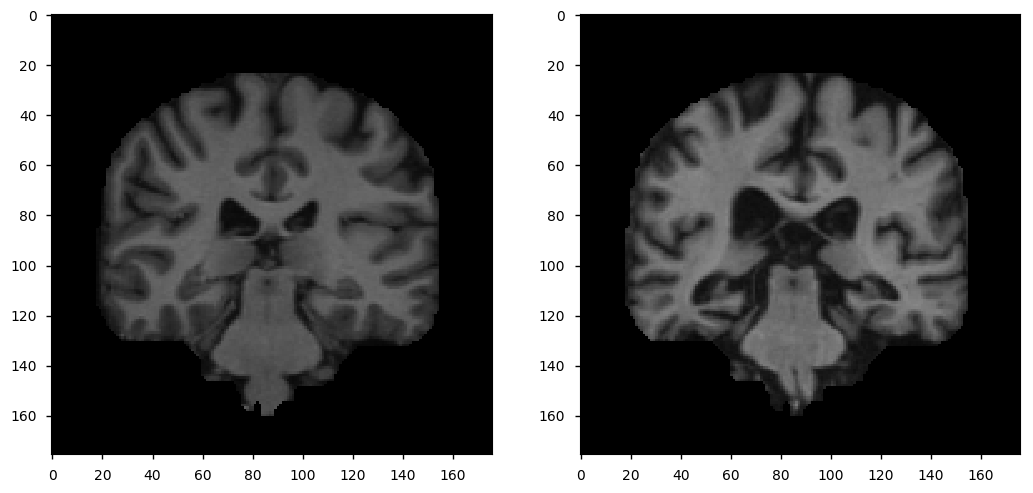

In [70]:
plt.figure(1, figsize=(12.5, 7.5), dpi=100)
plt.subplot(121)
plt.imshow(cv2.imread("{}".format(coronal90loc[HealthyExampleIndex]))) 
plt.subplot(122)
plt.imshow(cv2.imread("{}".format(coronal90loc[SickExampleIndex]))) 
plt.show()

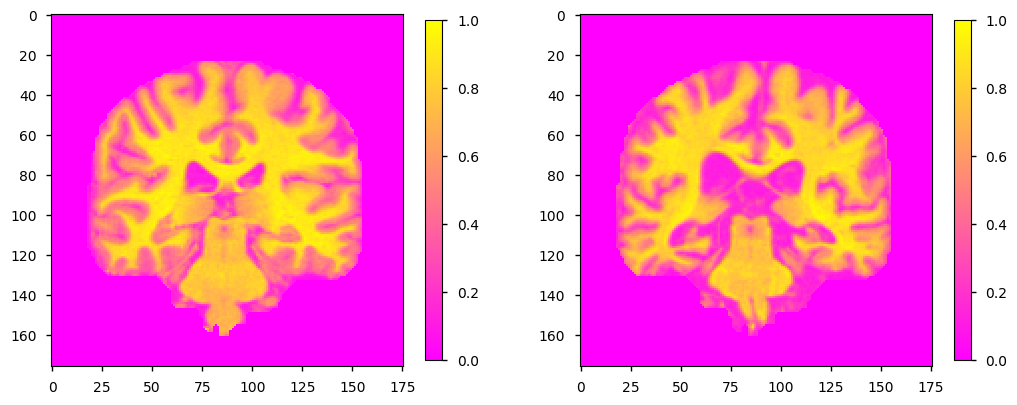

In [75]:
plt.figure(2, figsize=(12.5, 7.5), dpi=100)

plt.subplot(121)
plt.imshow(coronal90_tensor[HealthyExampleIndex], cmap='spring')
plt.colorbar(orientation='vertical', shrink=0.6)

plt.subplot(122)
plt.imshow(coronal90_tensor[SickExampleIndex], cmap='spring')

plt.colorbar(orientation='vertical', shrink=0.6)

plt.show()

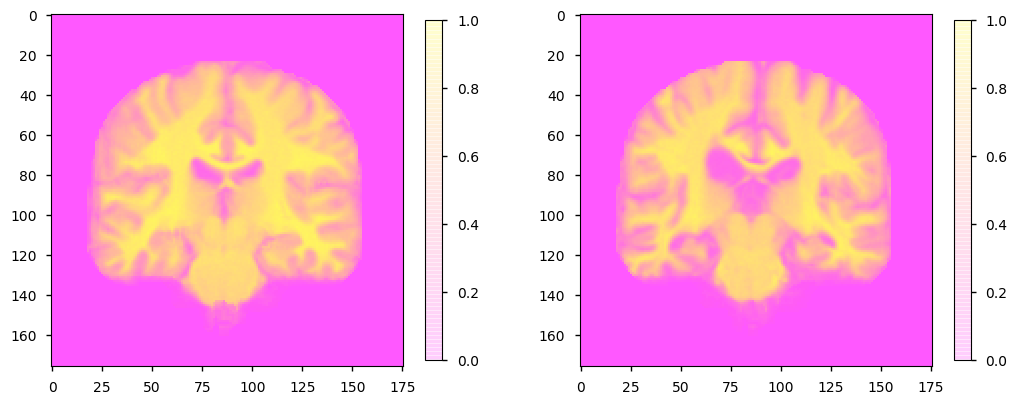

In [77]:
patient_holder = []

for i in range(0,216):
    #print("concatenating patient {}".format(i))
    one_patient = [coronal90_tensor[i],
                  coronal91_tensor[i],
                  coronal92_tensor[i],
                  coronal93_tensor[i],
                  coronal94_tensor[i],
                  coronal95_tensor[i],
                  coronal96_tensor[i],
                  coronal97_tensor[i],
                  coronal98_tensor[i],
                  coronal99_tensor[i]]
    one_patient = np.asarray(one_patient)
    one_patient = np.moveaxis(one_patient, 0, -1)
    patient_holder.append(one_patient)
    
patient_holder = np.asarray(patient_holder)

plt.figure(3, figsize=(12.5, 7.5), dpi=100)

plt.subplot(121)
plt.imshow(coronal90_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal91_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal92_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal93_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal94_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal95_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal96_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal97_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal98_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal99_tensor[HealthyExampleIndex], cmap='spring', alpha=0.1)
plt.colorbar(orientation='vertical', shrink=0.6)

plt.subplot(122)
plt.imshow(coronal90_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal91_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal92_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal93_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal94_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal95_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal96_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal97_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal98_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.imshow(coronal99_tensor[SickExampleIndex], cmap='spring', alpha=0.1)
plt.colorbar(orientation='vertical', shrink=0.6)

plt.show()

In [12]:
import keras 
import tensorflow as tf

print('Keras: ', keras.__version__, 'Tensorflow: ', tf.__version__)

Using TensorFlow backend.


Keras:  2.1.3 Tensorflow:  1.2.1


In [13]:
train_percentage_as_decimal = 0.60
end = round(train_percentage_as_decimal*patient_holder.shape[0])

X_train_tensor = patient_holder[0:end]
Y_train_output = Y_CDR_encoded[0:end]
X_test_tensor = patient_holder[end:patient_holder.shape[0]]
Y_test_output = Y_CDR_encoded[end:patient_holder.shape[0]]

print(Y_train_output.shape)
print("{}% of the training sample has No Condition".format((100*Y_train_output[:,0].sum()/Y_train_output.shape[0])))
print("{}% of the training sample has Alzheimer's Disease".format((100*Y_train_output[:,1].sum()/Y_train_output.shape[0])))
print(Y_test_output.shape)
print("{}% of the validation testing sample has No Condition".format((100*Y_test_output[:,0].sum()/Y_test_output.shape[0])))
print("{}% of the training sample has Alzheimer's Disease".format((100*Y_test_output[:,1].sum()/Y_test_output.shape[0])))

(130, 2)
64.61538461538461% of the training sample has No Condition
35.38461538461539% of the training sample has Alzheimer's Disease
(86, 2)
56.97674418604651% of the validation testing sample has No Condition
43.02325581395349% of the training sample has Alzheimer's Disease


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

bad_model = Sequential()
bad_model.add(Flatten(input_shape=(176,176,10)))
bad_model.add(Dense(2, activation='softmax'))
bad_model.summary()
bad_model.compile(loss='binary_crossentropy',
               optimizer='sgd',
               metrics=['binary_accuracy'])
bad_model.fit(X_train_tensor, Y_train_output, epochs=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 309760)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 619522    
Total params: 619,522
Trainable params: 619,522
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
130/130 [==============================] - 1s 11ms/step - loss: 3.7007 - binary_accuracy: 0.6538
Epoch 2/5
130/130 [==============================] - 1s 5ms/step - loss: 10.3580 - binary_accuracy: 0.3538
Epoch 3/5
130/130 [==============================] - 1s 5ms/step - loss: 10.3580 - binary_accuracy: 0.3538
Epoch 4/5
130/130 [==============================] - 1s 5ms/step - loss: 10.3580 - binary_accuracy: 0.3538
Epoch 5/5
130/130 [==============================] - 1s 5ms/step - loss: 10.3580 - binary_accuracy: 0.35

In [15]:
bad_model.evaluate(X_test_tensor, Y_test_output)

86/86 [==============================] - 0s 4ms/step


[9.1335088375002833, 0.43023255813953487]

In [26]:
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(176,176,10)))
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.95))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
               optimizer='sgd',
               metrics=['binary_accuracy'])

model.fit(X_train_tensor, Y_train_output,
          batch_size=32,
          epochs=8,
          verbose=1,
          shuffle=True,
          validation_data=(X_test_tensor, Y_test_output))

score = model.evaluate(X_test_tensor, Y_test_output)

print('\nTest loss:', score[0])
print('\nTest accuracy:', score[1])

Train on 130 samples, validate on 86 samples
Epoch 1/8
130/130 [==============================] - 31s 235ms/step - loss: 5.2008 - binary_accuracy: 0.6000 - val_loss: 6.8967 - val_binary_accuracy: 0.5698
Epoch 2/8
130/130 [==============================] - 30s 233ms/step - loss: 5.6722 - binary_accuracy: 0.6462 - val_loss: 6.8967 - val_binary_accuracy: 0.5698
Epoch 3/8
130/130 [==============================] - 31s 235ms/step - loss: 5.6727 - binary_accuracy: 0.6462 - val_loss: 6.8967 - val_binary_accuracy: 0.5698
Epoch 4/8
130/130 [==============================] - 30s 227ms/step - loss: 5.6722 - binary_accuracy: 0.6462 - val_loss: 6.8967 - val_binary_accuracy: 0.5698
Epoch 5/8
130/130 [==============================] - 30s 228ms/step - loss: 5.6722 - binary_accuracy: 0.6462 - val_loss: 6.8967 - val_binary_accuracy: 0.5698
Epoch 6/8
130/130 [==============================] - 30s 229ms/step - loss: 5.6722 - binary_accuracy: 0.6462 - val_loss: 6.8967 - val_binary_accuracy: 0.5698
Epoch 7

In [17]:
def auto_canny(image):
    imagef = np.ndarray.flatten(image)
    # compute the mean of the single channel pixel intensities
    m = np.mean(imagef)
    s = np.std(imagef)
 
    # apply automatic Canny edge detection using the computed mean
    lower = int(max(np.min(imagef), m-2*s))
    upper = int(min(np.max(imagef), m+2*s))
    edged = cv2.Canny(image, lower, upper, apertureSize=3, L2gradient=True)
 
    # return the edged image
    return edged

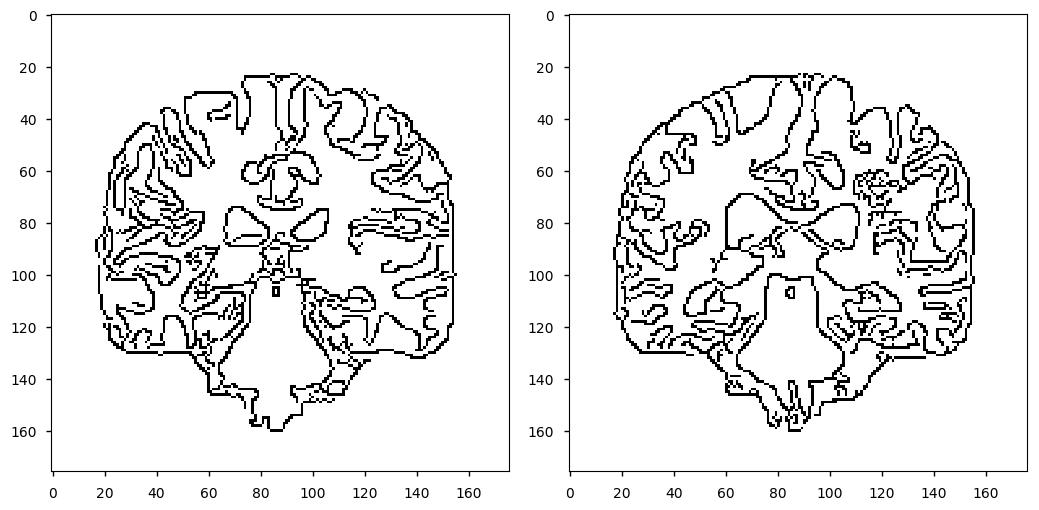

In [18]:
healthyIMAGE = cv2.imread("{}".format(coronal90loc[HealthyExampleIndex]))
sickIMAGE = cv2.imread("{}".format(coronal90loc[SickExampleIndex]))

plt.figure(3, figsize=(10.5, 7.5), dpi=100)

plt.subplot(121)
plt.imshow(auto_canny(healthyIMAGE), cmap='binary')
plt.tight_layout()

plt.subplot(122)
plt.imshow(auto_canny(sickIMAGE), cmap='binary')
plt.tight_layout()

plt.show()

In [23]:
def edgesMarrHildreth(img, sigma):
    """
        finds the edges using Marr Hildreth edge detection method...
        :param im : input image
        :param sigma : sigma is the std-deviation and refers to the spread of gaussian
        :return:
    a binary edge image...
    """
    size = int(2*(np.ceil(3*sigma))+1)

    x, y = np.meshgrid(np.arange(-size/2+1, size/2+1), np.arange(-size/2+1, size/2+1))
    
    normal = 1 / (2.0 * np.pi * sigma**2)
    kernel = ((x**2 + y**2 - (2.0*sigma**2)) / sigma**4) * np.exp(-(x**2+y**2) / (2.0*sigma**2)) / normal # LoG filter

    kern_size = kernel.shape[0]
    log = np.zeros_like(img, dtype=float)

    # applying filter
    for i in range(img.shape[0]-(kern_size-1)):
        for j in range(img.shape[1]-(kern_size-1)):
            window = img[i:i+kern_size, j:j+kern_size] * kernel
            log[i,j] = np.sum(window)

    log = log.astype(np.int64, copy=False)

    zero_crossing = np.zeros_like(log)

    # computing zero crossing
    for i in range(log.shape[0]-(kern_size-1)):
        for j in range(log.shape[1]-(kern_size-1)):
            if log[i][j] == 0:
                if (log[i][j-1] < 0 and log[i][j+1] > 0) or (log[i][j-1] < 0 and log[i][j+1] < 0) or (log[i-1][j] < 0 and log[i+1][j] > 0) or (log[i-1][j] > 0 and log[i+1][j] < 0):
                    zero_crossing[i][j] = 255
            elif log[i][j] < 0:
                if (log[i][j-1] > 0) or (log[i][j+1] > 0) or (log[i-1][j] > 0) or (log[i+1][j] > 0):
                    zero_crossing[i][j] = 255

    hzeroes = np.reshape(np.zeros(zero_crossing.shape[0]), newshape=(176,1))
    vzeroes = np.reshape(np.zeros(zero_crossing.shape[0]), newshape=(1,176))
    for i in range(10):
        zero_crossing = np.hstack((hzeroes,zero_crossing))
        zero_crossing = np.delete(zero_crossing, -1, axis=1)
    for i in range(10):
        zero_crossing = np.vstack((vzeroes,zero_crossing))
        zero_crossing = np.delete(zero_crossing, -1, axis=0)

   
    return(zero_crossing)

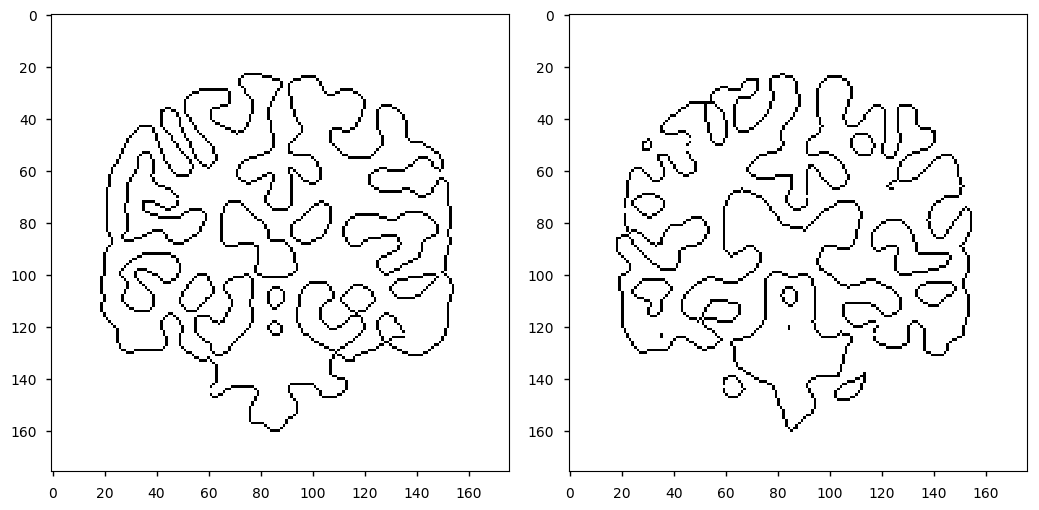

In [24]:
plt.figure(3, figsize=(10.5, 7.5), dpi=100)

plt.subplot(121)
plt.imshow(edgesMarrHildreth(coronal90_tensor[HealthyExampleIndex], 3.5), cmap='binary')
plt.tight_layout()

plt.subplot(122)
plt.imshow(edgesMarrHildreth(coronal90_tensor[SickExampleIndex], 3.5), cmap='binary')
plt.tight_layout()

plt.show()

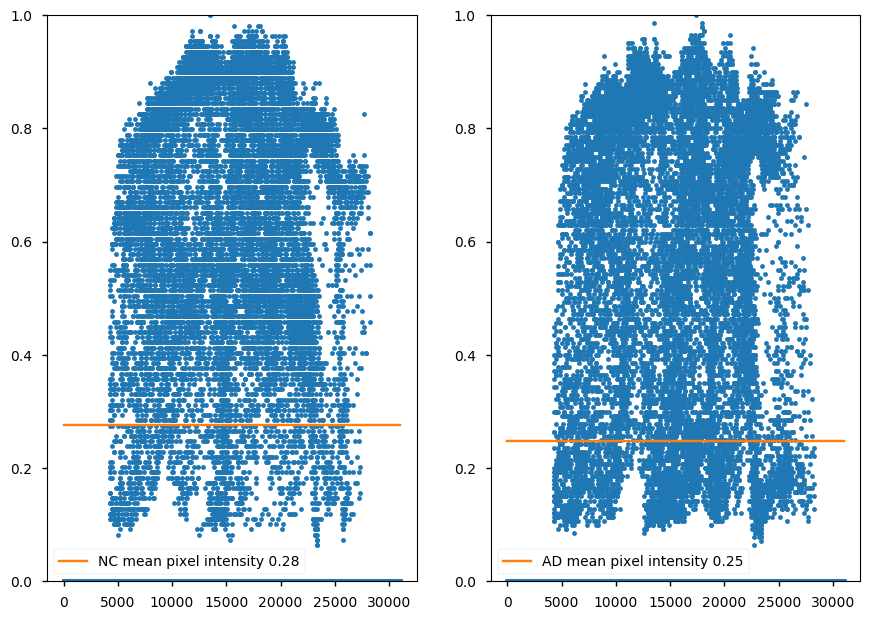

In [21]:
healthyFlatten = np.ndarray.flatten(coronal90_tensor[HealthyExampleIndex])
sickFlatten = np.ndarray.flatten(coronal90_tensor[SickExampleIndex])

plt.figure(3, figsize=(10.5, 7.5), dpi=100)

plt.subplot(121)
plt.plot((healthyFlatten), '.')
plt.plot([0, healthyFlatten.shape[0]], [healthyFlatten.mean(), healthyFlatten.mean()], label="NC mean pixel intensity {}".format(round(healthyFlatten.mean(), 2)))
plt.ylim(0,1)
plt.legend()

plt.subplot(122)
plt.plot((sickFlatten), '.')
plt.plot([0, sickFlatten.shape[0]], [sickFlatten.mean(), sickFlatten.mean()], label="AD mean pixel intensity {}".format(round(sickFlatten.mean(), 2)))
plt.ylim(0,1)
plt.legend()

plt.show()

C:\Users\Shak3\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Shak3\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Shak3\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


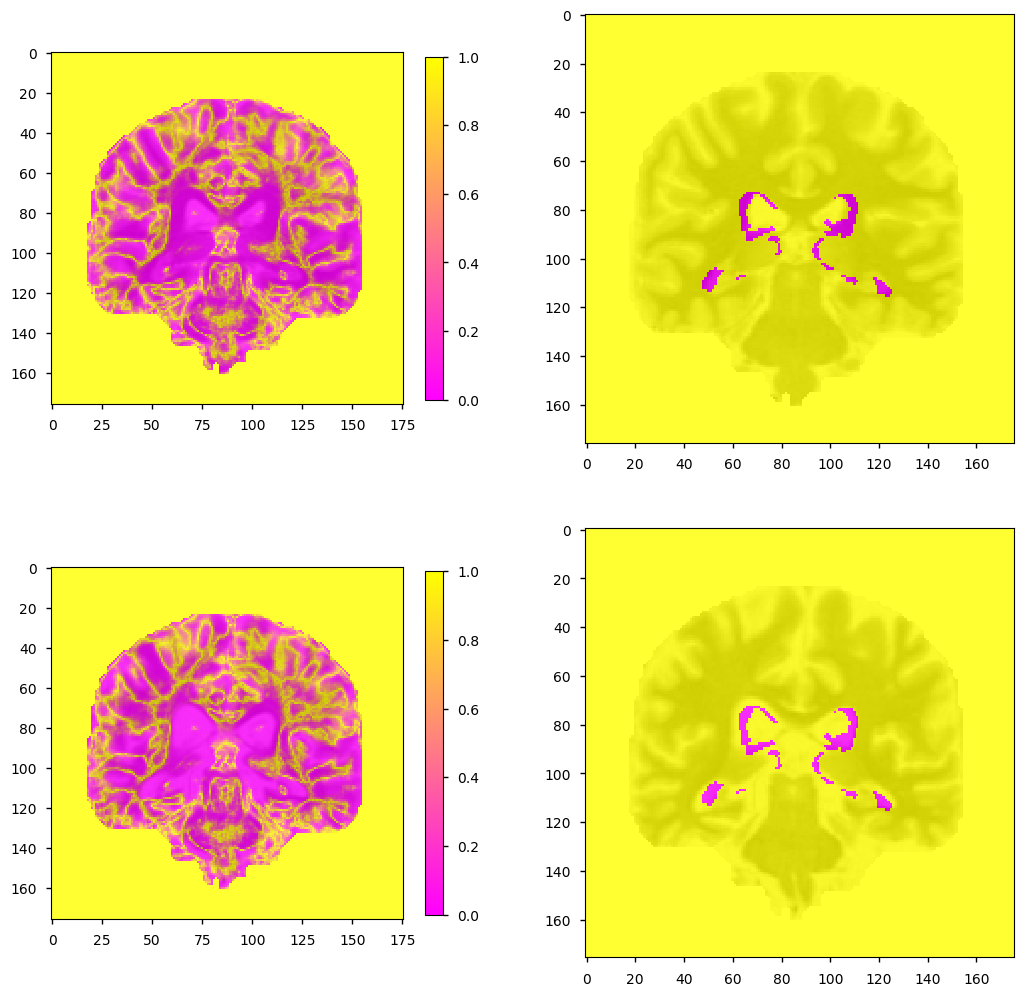

In [140]:
import scipy
import math
from scipy import stats

nrow = 176
ncol = 176
alpha = 0.05/(nrow*ncol)

PM = np.array([[0]*nrow]*ncol, dtype='float')
PMsig = np.array([[0]*nrow]*ncol, dtype='float')

for row in range(nrow):
    for col in range(ncol):        
        tstat, pval = stats.ttest_ind(coronal90_tensor[:,row,col][Y_CDR_binary==-1], coronal90_tensor[:,row,col][Y_CDR_binary==1], equal_var=False)
        if math.isnan(tstat):
            PM[row,col] = 1
            PMsig[row,col] = 1
        else:
            PM[row,col] = pval
            if pval > alpha:
                PMsig[row,col] = 1
            else:
                PMsig[row,col] = 0

plt.figure(3, figsize=(12.5, 12.5), dpi=100)

plt.subplot(221)
plt.imshow(PM, cmap='spring')
plt.colorbar(orientation='vertical', cmap='spring', shrink=0.8)
plt.imshow(coronal90_tensor[HealthyExampleIndex], cmap='binary', alpha=0.2)

plt.subplot(222)
plt.imshow(PMsig, cmap='spring')
plt.imshow(coronal90_tensor[HealthyExampleIndex], cmap='binary', alpha=0.2)

plt.subplot(223)
plt.imshow(PM, cmap='spring')
plt.colorbar(orientation='vertical', cmap='spring', shrink=0.8)
plt.imshow(coronal90_tensor[SickExampleIndex], cmap='binary', alpha=0.2)

plt.subplot(224)
plt.imshow(PMsig, cmap='spring')
plt.imshow(coronal90_tensor[SickExampleIndex], cmap='binary', alpha=0.2)

plt.show()

In [143]:
big_ol_X_matrix = np.stack((X_sex_binary, X_age, X_education, X_SES, X_eTIV, X_nWBV, X_ASF,Y_CDR_binary), axis=1)

In [154]:
from sklearn.linear_model import LinearRegression

nrow = 176
ncol = 176
alpha = 0.05/(nrow*ncol)

sex_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')
age_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')
educ_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')
ses_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')
etiv_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')
nwbv_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')
asf_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')
dis_beta_holder = np.array([[0]*nrow]*ncol, dtype='float')


for row in range(nrow):
    for col in range(ncol):        
        yforlinreg = coronal90_tensor[:,row,col]
        linreg = LinearRegression()
        linreg.fit(X=big_ol_X_matrix, y=yforlinreg)
        sex_beta = linreg.coef_[0]
        age_beta = linreg.coef_[1]
        educ_beta = linreg.coef_[2]
        ses_beta = linreg.coef_[3]
        etiv_beta = linreg.coef_[4]
        nwbv_beta = linreg.coef_[5]
        asf_beta = linreg.coef_[6]
        dis_beta = linreg.coef_[7]

        sex_beta_holder[row,col] = sex_beta
        age_beta_holder[row,col] = age_beta
        educ_beta_holder[row,col] = educ_beta
        ses_beta_holder[row,col] = ses_beta
        etiv_beta_holder[row,col] = etiv_beta
        nwbv_beta_holder[row,col] = nwbv_beta
        asf_beta_holder[row,col] = asf_beta
        dis_beta_holder[row,col] = dis_beta

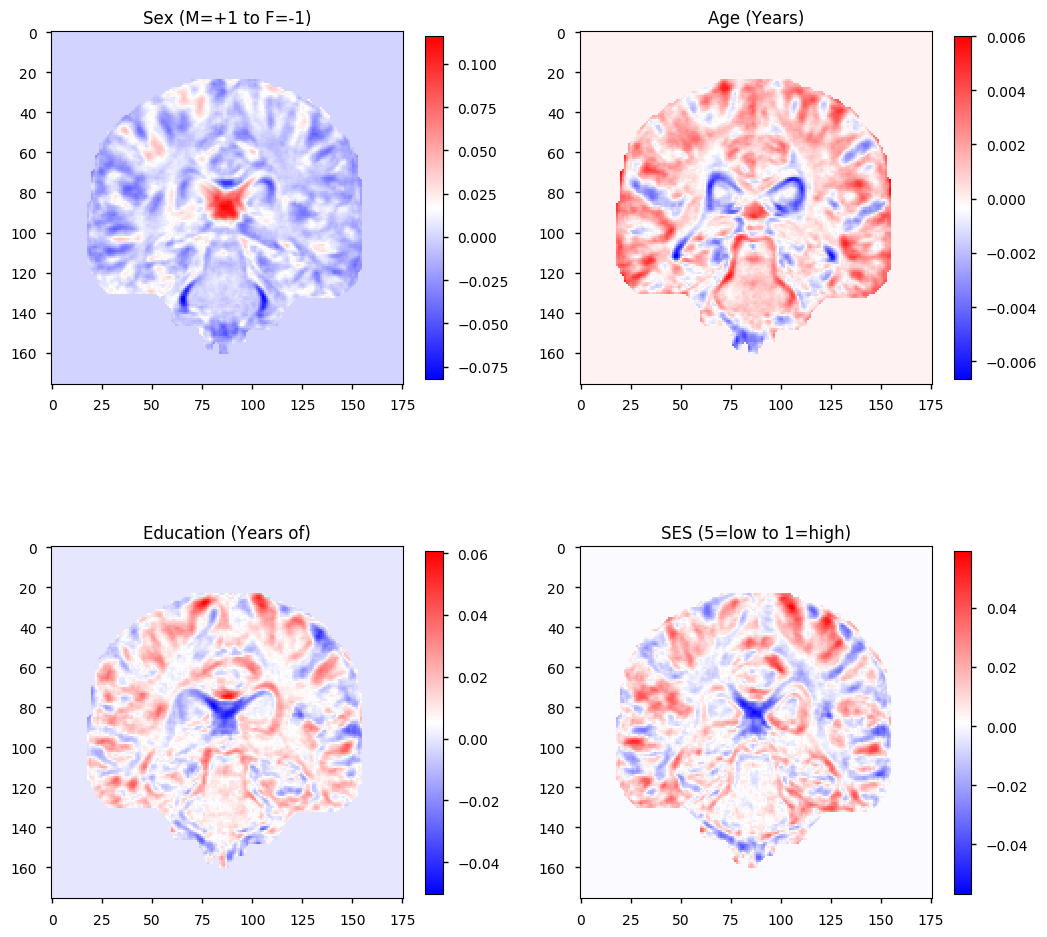

In [200]:
plt.figure(3, figsize=(12.5, 12.5), dpi=100)

plt.subplot(221)
plt.imshow(sex_beta_holder, cmap='bwr', label='Sex (M=+1 to F=-1)')
plt.title('Sex (M=+1 to F=-1)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.8)

plt.subplot(222)
plt.imshow(age_beta_holder, cmap='bwr', label='Age (Years)')
plt.title('Age (Years)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.8)

plt.subplot(223)
plt.imshow(educ_beta_holder, cmap='bwr', label='Education (Years of)')
plt.title('Education (Years of)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.8)

plt.subplot(224)
plt.imshow(ses_beta_holder, cmap='bwr', label='(SES 5=low to 1=high)')
plt.title('SES (5=low to 1=high)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.8)

plt.show()

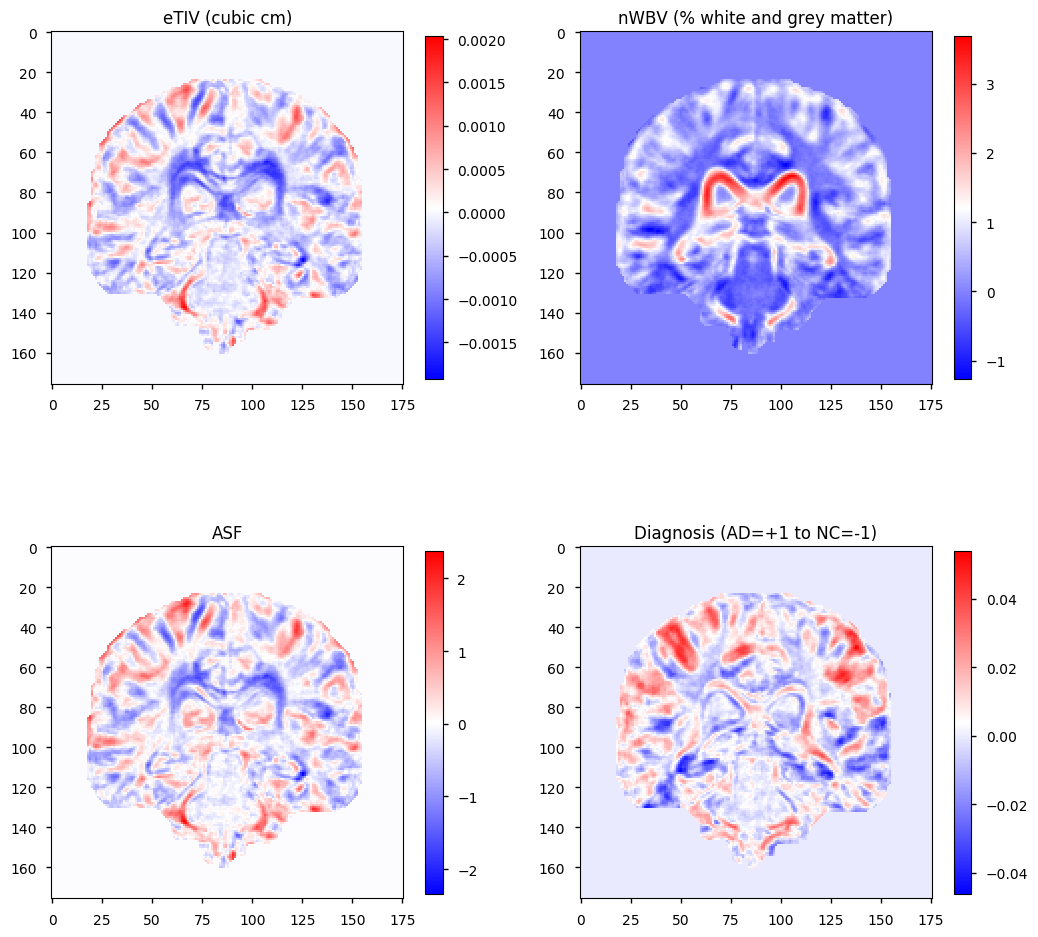

In [202]:
plt.figure(3, figsize=(12.5, 12.5), dpi=100)

plt.subplot(221)
plt.imshow(etiv_beta_holder, cmap='bwr', label='eTIV (cubic cm)')
plt.title('eTIV (cubic cm)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.8)

plt.subplot(222)
plt.imshow(nwbv_beta_holder, cmap='bwr', label='nWBV (% white and grey matter)')
plt.title('nWBV (% white and grey matter)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.8)

plt.subplot(223)
plt.imshow(asf_beta_holder, cmap='bwr', label='ASF')
plt.title('ASF')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.8)

plt.subplot(224)
plt.imshow(dis_beta_holder, cmap='bwr', label='Diagnosis (AD=+1 to NC=-1)')
plt.title('Diagnosis (AD=+1 to NC=-1)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.8)

plt.show()

In [209]:
big_ol_X_matrix2 = np.stack((X_sex_binary, X_age, Y_CDR_binary), axis=1)

In [210]:
from sklearn.linear_model import LinearRegression

nrow = 176
ncol = 176
alpha = 0.05/(nrow*ncol)

sex_beta_holder2 = np.array([[0]*nrow]*ncol, dtype='float')
age_beta_holder2 = np.array([[0]*nrow]*ncol, dtype='float')
dis_beta_holder2 = np.array([[0]*nrow]*ncol, dtype='float')


for row in range(nrow):
    for col in range(ncol):        
        yforlinreg = coronal90_tensor[:,row,col]
        linreg2 = LinearRegression()
        linreg2.fit(X=big_ol_X_matrix2, y=yforlinreg)
        sex_beta2 = linreg2.coef_[0]
        age_beta2 = linreg2.coef_[1]
        dis_beta2 = linreg2.coef_[2]

        sex_beta_holder2[row,col] = sex_beta2
        age_beta_holder2[row,col] = age_beta2
        dis_beta_holder2[row,col] = dis_beta2

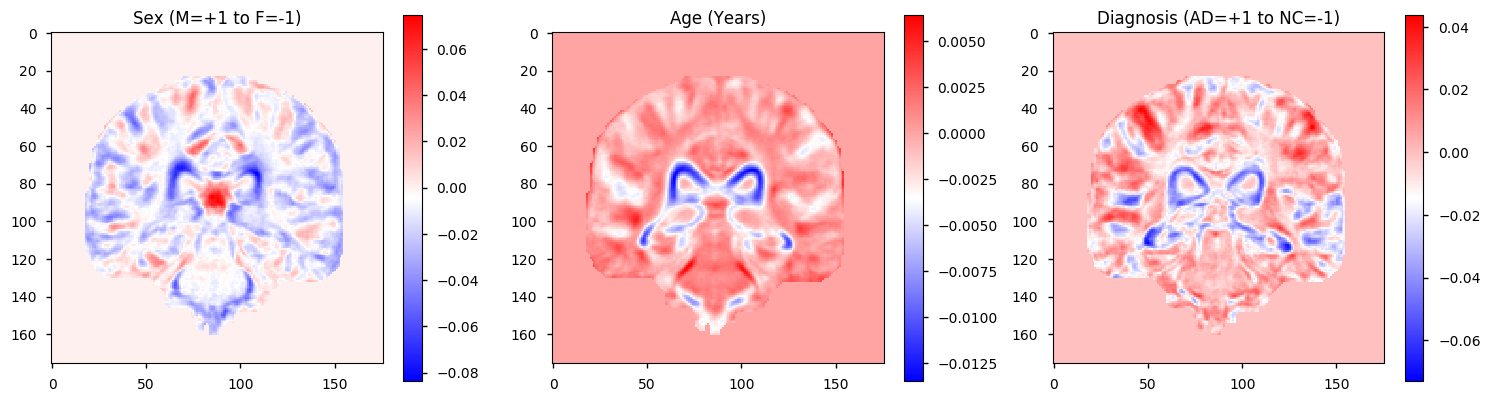

In [228]:
plt.figure(3, figsize=(15, 12.5), dpi=100)

plt.subplot(131)
plt.imshow(sex_beta_holder2, cmap='bwr', label='Sex (M=+1 to F=-1)')
plt.tight_layout()
plt.title('Sex (M=+1 to F=-1)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.3)
plt.tight_layout()

plt.subplot(132)
plt.imshow(age_beta_holder2, cmap='bwr', label='Age (Years)')
plt.tight_layout()
plt.title('Age (Years)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.3)
plt.tight_layout()

plt.subplot(133)
plt.imshow(dis_beta_holder2, cmap='bwr', label='Diagnosis (AD=+1 to NC=-1)')
plt.tight_layout()
plt.title('Diagnosis (AD=+1 to NC=-1)')
plt.colorbar(orientation='vertical', cmap='bwr', shrink=0.3)
plt.tight_layout()

plt.show()